# ADAM-DS data retrieve and image visualization example

Here we use Python ADAM API to access imagery data from the data store and simply visualize.

In [1]:
import os
import json
import fiona
import shutil
import rasterio
import numpy as np
import pandas as pd
import adamapi as adam
import matplotlib.pyplot as plt

## Authenticate user

First thing we have to do is to authenticate our user. This is easily done once connected to ADAM explorer, in dashboard.

In [2]:
from adamapi import Auth

a = Auth()
a.setKey("7OSyxWA_tZgTEo66g4NTkDPQGLAGWuNa6oJ_Nx7dWjY")
a.setAdamCore("https://explorer-space.adamplatform.eu/")
a.authorize()

{'expires_at': '2021-06-07T13:59:30.416Z',
 'access_token': '978124b40c5249178167e702e57a5093',
 'refresh_token': 'da2a9e4b8b4d4710a7a273aa7362f57a',
 'expires_in': 3600}

## Query available datasets

Supposing we don't know the available datasets, we can easily query the data store to list available options.

In [3]:
datasets = adam.Datasets(a)
items = datasets.getDatasets()

print(json.dumps(items, indent=2))

{
  "type": "FeatureCollection",
  "properties": {
    "totalResults": 1,
    "itemsPerPage": 1,
    "maxRecords": 10,
    "page": 0
  },
  "content": [
    {
      "datasetId": "58592:MRO_CTX",
      "title": "Mars Reconnaissance Orbiter - Context Camera",
      "description": "Products from Context Camera instrument in Mars Reconnaissance Orbiter",
      "startDate": "2006-03-24T04:41:07Z",
      "endDate": "2020-08-31T18:19:37Z"
    }
  ]
}


Here, for instance, `MRO_CTX` is available for our public access... let's see how many data products are in there.

In [4]:
ctx_dataset = datasets.getDatasets( '58592:MRO_CTX' )

print(f"Number of images: {ctx_dataset['numberOfRecords']}")

Number of images: 6495


## Query data products inside bounding-box

Considering we have a location of interest where we want to get images from, we can ask ADAM for that.

In [5]:
datasetId='58592:MRO_CTX'

search=adam.Search(a)

search_result=search.getProducts(
    datasetId,
    geometry={"type":"Polygon","coordinates":[[[-101,14],[-98,14],[-98,21],[-101,21],[-101,14]]]},
    startIndex=0,
    maxRecords=10)

print("Number of products found:", len(search_result['content']))

Number of products found: 10


## Visualize queried data products

Let's have a quick look of the data products -- their footprints -- we just queried.
Sure enough, such plot is a subset of what we had/have from ADAM-Explorer.

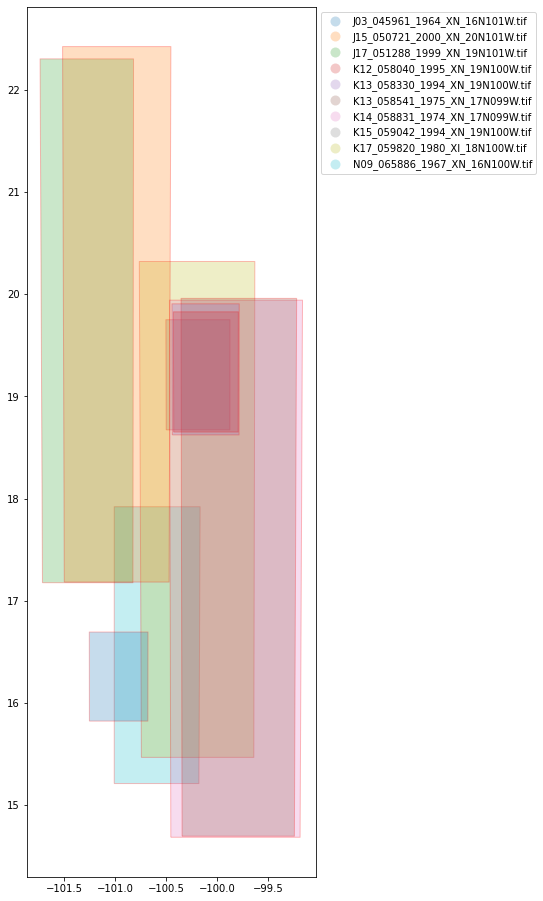

In [6]:
%matplotlib inline

import geopandas
from shapely.geometry import shape

_gd = {'productId':[], 'geometry':[]}
for p in search_result['content']:
    _gd['productId'].append(p['productId'])
    _gd['geometry'].append(shape(p['geometry']['geometries'][0]))
    
gdf = geopandas.GeoDataFrame(_gd)

gdf.plot(alpha=0.25, edgecolor='red', legend=True, column='productId', legend_kwds={'loc': 'upper left', 'bbox_to_anchor': (1, 1)}, 
         figsize=(24,16));

## Download a sample

Now that we have identify a set of images/region of interest visualization:
```
- J03_045961_1964_XN_16N101W.tif
```

In [7]:
products = [
    'J03_045961_1964_XN_16N101W.tif'
]

In [8]:
from pathlib import Path

datapath = Path('data')
outpath = datapath / 'adamapiresults'

zips = []
for product in products:
    _tif = outpath / product
    _zip = _tif.with_suffix('.zip')
    if _zip.exists():
        print(f"Product '{product}' already downloaded")
        zips.append(_zip)
        continue
    print(f"Requesting '{product}'")
    
    # ----------------------
    # Here we efectively request the data to ADAM...the rest is just boilerplating for writing/checking downloads
    _out = adam.GetData(a).getData(datasetId, productId=product, outputFname=_zip.as_posix())
    # ----------------------

    assert _out == _zip.as_posix()
    zips.append(_zip)

tiffs = []
for _zip in zips:
    _tif = _zip.with_suffix('.tif')
    shutil.unpack_archive(_zip, 'adamapiresults')
    tiffs.append(_tif)
    
tiffs

Product 'J03_045961_1964_XN_16N101W.tif' already downloaded


[PosixPath('data/adamapiresults/J03_045961_1964_XN_16N101W.tif')]

## Visualize image

Let's quick visualize it using Python matplotlib.

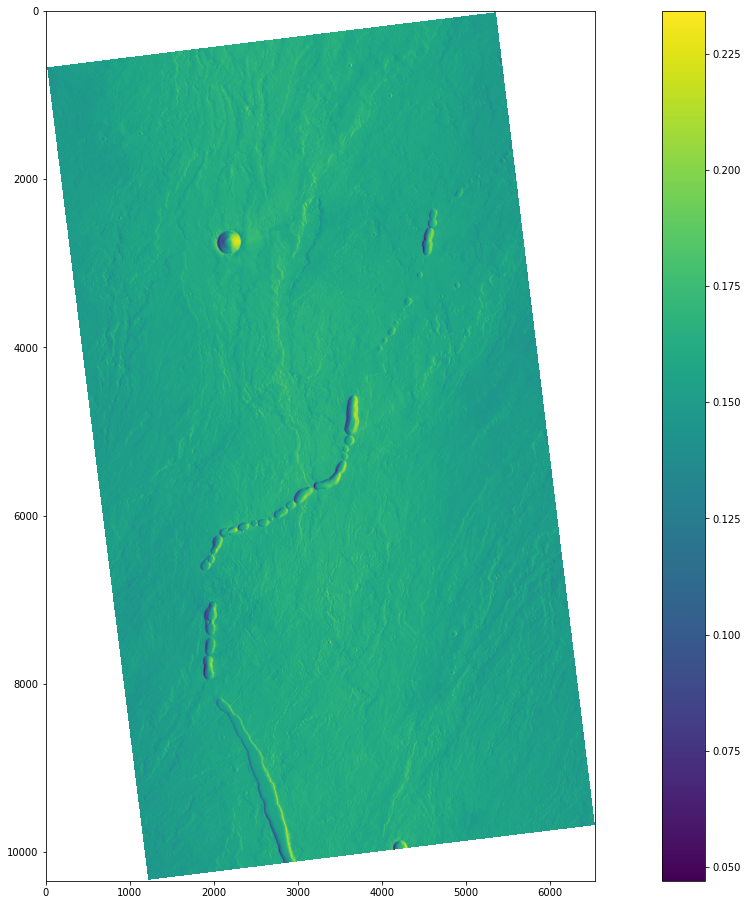

In [9]:
with rasterio.open('adamapiresults/J03_045961_1964_XN_16N101W.tif') as tif:
    img = tif.read(1)
    img[img<=tif.nodata] = np.nan

plt.subplots(figsize=(24,16))
plt.imshow(img, cmap = 'viridis')
plt.colorbar()